# Example 1:Hinge and Square Loss
This example try to show how to use our PLQ Composite Decomposition tool to decompose a Loss function

Given a loss function $L(z)=max(max(1-z,0)),\frac{1}{2} (1-z)^2 )$

# 1.Data Generation

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from plqcom.PLQLoss import PLQLoss
from plqcom.ReHProperty import affine_transformation
from rehline import ReHLine
from rehline._base import relu, rehu

In [27]:
# Generate a random classification problem
n, d, C = 1000, 3, 0.5
np.random.seed(1024)
X = np.random.randn(1000, 3)
beta = np.random.randn(3)
y = np.sign(X.dot(beta) + np.random.randn(n))

In [28]:
X[:10], y[:10]

(array([[ 2.12444863,  0.25264613,  1.45417876],
        [ 0.56923979,  0.45822365, -0.80933344],
        [ 0.86407349,  0.20170137, -1.87529904],
        [-0.56850693, -0.06510141,  0.80681666],
        [-0.5778176 ,  0.57306064, -0.33667496],
        [ 0.29700734, -0.37480416,  0.15510474],
        [ 0.70485719,  0.8452178 , -0.65818079],
        [ 0.56810558,  0.51538125, -0.61564998],
        [ 0.92611427, -1.28591285,  1.43014026],
        [-0.4254975 , -0.40257712,  0.60410409]]),
 array([ 1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.]))

# 2. Create and Decompose the PLQ Loss

In [29]:
z = np.linspace(-2, 2, 100)
L1 = np.maximum(1-z,0)
L2 = 0.5*(1-z)**2

Text(0.5, 1.0, 'Hinge Loss and Square Loss')

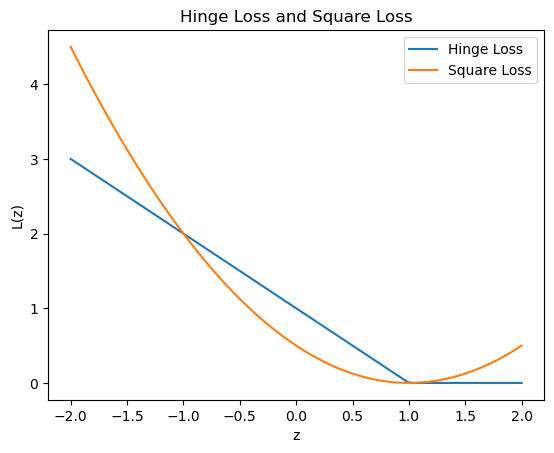

In [30]:
plt.plot(z, L1, label='Hinge Loss')
plt.plot(z, L2, label='Square Loss')
plt.legend()
plt.xlabel('z')
plt.ylabel('L(z)')
plt.title('Hinge Loss and Square Loss')

In [31]:
plqloss = PLQLoss(quad_coef={'a': np.array([0., 0., 0.5]), 'b': np.array([0., -1., -1.]), 'c': np.array([0., 1., 0.5])},
                  form='minimax')
rehloss = plqloss._2ReHLoss()

In [32]:
rehloss.relu_coef, rehloss.relu_intercept, rehloss.rehu_cut, rehloss.rehu_coef, rehloss.rehu_intercept

(array([[-1.],
        [-1.]]),
 array([[ 1.],
        [-1.]]),
 array([[inf],
        [inf]]),
 array([[ 1.],
        [-1.]]),
 array([[-1.],
        [-1.]]))

<Figure size 640x480 with 0 Axes>

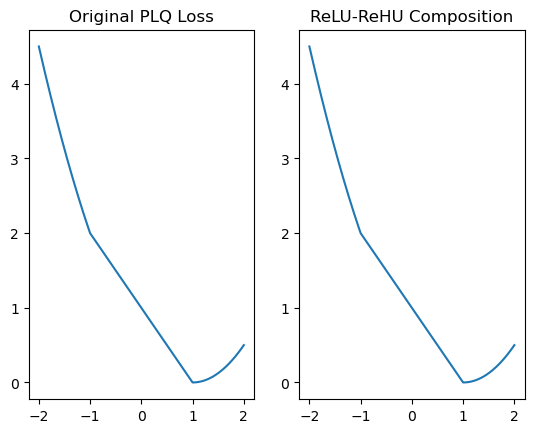

<Figure size 640x480 with 0 Axes>

In [33]:
plt.subplot(1, 2, 1)
Z = np.linspace(-2, 2, 1000)
L = plqloss(Z)
plt.plot(Z, L)
plt.title('Original PLQ Loss')


plt.subplot(1, 2, 2)
relu_coef, relu_intercept = rehloss.relu_coef, rehloss.relu_intercept
rehu_cut, rehu_coef, rehu_intercept = rehloss.rehu_cut, rehloss.rehu_coef, rehloss.rehu_intercept
Reh=np.sum(rehu(rehu_coef*Z+rehu_intercept, rehu_cut),axis=0) + np.sum(relu(relu_coef*Z+relu_intercept),axis=0)
plt.plot(Z, Reh)
plt.title('ReLU-ReHU Composition')
plt.figure()

# 3.Broadcast to all samples

In [34]:
rehloss = affine_transformation(rehloss, n=X.shape[0], c=C, p=y, q=0)

In [35]:
rehloss.relu_coef, rehloss.relu_intercept,rehloss.rehu_cut, rehloss.rehu_coef, rehloss.rehu_intercept

(array([[-0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5],
        [-0.5,  0.5,  0.5, ...,  0.5,  0.5, -0.5]]),
 array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
        [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]]),
 array([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]]),
 array([[ 0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
         -0.70710678,  0.70710678],
        [-0.70710678,  0.70710678,  0.70710678, ...,  0.70710678,
          0.70710678, -0.70710678]]),
 array([[-0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
         -0.70710678, -0.70710678],
        [-0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
         -0.70710678, -0.70710678]]))

# 4. Use ReHLine to solve the problem

In [37]:
clf = ReHLine(loss={'name': 'custom'}, C=C)
clf.U, clf.V, clf.Tau, clf.S, clf.T= rehloss.relu_coef, rehloss.relu_intercept,rehloss.rehu_cut, rehloss.rehu_coef, rehloss.rehu_intercept
clf.fit(X=X)
print('sol privided by rehline: %s' % clf.coef_)

sol privided by rehline: [ 0.27581282 -0.02325025  0.85249357]
